In [10]:
#loading data
import pandas as pd
import numpy as np

df= pd.read_csv('luxstay_hanoi_27-12-2019_feature_eng.csv')
df= df.sample(frac= 1, random_state= 1).reset_index(drop= True)

X, y= df.drop('price', axis= 1), df['price']

## Impletmenting FISTA

In [8]:
#import lib
from math import sqrt
import numpy as np
from numpy.linalg import norm

np.random.seed(23) #set seed for same experimental results

def soft_thresh(w,l):
    return np.sign(w)*np.maximum(np.abs(w)-l, 0)

def fista_imp(X, y, l):
    w= np.zeros(X.shape[1])
    Losses= []
    t= 1
    v= w.copy()
    
    L= norm(X.T.dot(X)) #lipschitz constrain
    
    max_iter = 1000
    
    for i in range(max_iter):
        w_old= w.copy()
        z=v-X.T.dot(X.dot(v)-y)/L
        w= soft_thresh(z, l/L)
        t_old= t
        t= (1+sqrt(1+4*t_old**2))/2
        v= w+((t_old - 1)/t)*(w - w_old)
        
        loss= 0.5*norm(X.dot(w)-y)**2+l*norm(w,ord=1)
        
        Losses.append(loss)
        print(f'Iteration {i+1}/{max_iter}: Loss= {loss:.2f}')
        
def fista_getw(X, y, l):
    w= np.zeros(X.shape[1])
    t= 1
    v= w.copy()
    
    L= norm(X.T.dot(X)) #lipschitz constrain
    
    max_iter = 1000
    
    for i in range(max_iter):
        w_old= w.copy()
        z=v-X.T.dot(X.dot(v)-y)/L
        w= soft_thresh(z, l/L)
        t_old= t
        t= (1+sqrt(1+4*t_old**2))/2
        v= w+((t_old - 1)/t)*(w - w_old)
        
        loss= 0.5*norm(X.dot(w)-y)**2+l*norm(w,ord=1)
        
    return w

def predict(X, w):
    return X.dot(w)


In [9]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score  

def k_fold_cross(k,data,alpha):
    mses=[]
    r2s= []
    data=data.sample(frac=1,random_state=1).reset_index(drop=True) #shuffle the data frame
    folds=np.array_split(data, k)
    # run into loops with different test set
    for i in range(k):
        #define train and test 
        train=folds.copy()
        test=folds[i]
        del train[i]
        train=pd.concat(train, sort=False)
        
        #train x and y
        x_train=np.array(train.drop('price',axis=1))
        y_train=np.array(train['price'])
        
        #test x and y
        x_test=np.array(test.drop('price',axis=1))
        y_test=np.array(test['price'])
        
        #fitting training x and y into model
        weight=fista_getw(x_train, y_train, alpha)
        
        #set up prediction and accuracy
        prediction=predict(x_test, weight)
        
        mse=mean_squared_error(y_test, prediction)
        r2=r2_score(y_test, prediction)
        
        mses.append(mse)
        r2s.append(r2)
    return np.mean(mses), np.mean(r2s)

def cross_poly_ridge(data):
    k=5
    #creating list of recrods
    alpha_points=[]
    degree_points=[]
    mses=[]
    r2s= []
    #define alpha
    alphas=np.logspace(-2,0,3)
    alphas=list(alphas)
    alphas.remove(1.0)
    for i in range(0,20):
        alphas.append(i)
    #ridge regression with different alpha:
    for alpha in alphas:
            mean_mse, mean_r2=k_fold_cross(k,data,alpha)
            mses.append(mean_mse)
            r2s.append(mean_r2)
            alpha_points.append(alpha)
    return alpha_points, mses, r2s

In [10]:
#testing fista
train= pd.read_csv('luxstay_hanoi_27-12-2019_feature_eng.csv')

Alpha,MSE, R2=cross_poly_ridge(train)

data_points={'Alpha':Alpha,'MSE':MSE, 'R2': R2} 
results=pd.DataFrame(data=data_points)
results.head()

,Alpha,MSE,R2
0,0.01,1519.809461,0.557894
1,0.10,1519.799751,0.557897
2,0.00,1519.810543,0.557893
3,1.00,1519.699815,0.557931
4,2.00,1519.591214,0.557969


In [11]:
results.to_csv('fista_results', index= False)

In [13]:
index=np.argmax(R2)
print('The best R2 is {p:.4f} and MSE is {m:.2f} for Alpha={a}'.format(p=max(R2), m=MSE[index], a=Alpha[index]))

The best R2 is 0.5580 and MSE is 1519.35 for Alpha=8


## Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid_rf= {
    'max_depth': ['none', 50, 60, 70, 80, 100],
    'max_features': [i for i in range(2, 12, 2)],
    'n_estimators': [i for i in range(100,1100,100)]
}

rf= RandomForestRegressor(random_state=23)

grid_search_rf= GridSearchCV(estimator= rf, param_grid= param_grid_rf, 
                         cv= 5, refit= 'r2', n_jobs= -1,
                         scoring= ['neg_mean_squared_error', 'r2'])

In [36]:
grid_search_rf.fit(X, y)

print(grid_search_rf.best_params_)

{'max_depth': 50, 'max_features': 10, 'n_estimators': 900}


In [37]:
best_rf= grid_search_rf.best_estimator_

from sklearn.model_selection import cross_validate

rf_cv= cross_validate(best_rf, X, y, cv=5, scoring= ['neg_mean_squared_error', 'r2'])
r2s_cv= rf_cv['test_r2']
mses_cv= abs(rf_cv['test_neg_mean_squared_error'])

print('R2 of the best model is {:.4f}'.format(np.mean(r2s_cv)))
print('MSE of the best model is {:.2f}'.format(np.mean(mses_cv)))

R2 of the best model is 0.5891
MSE of the best model is 1430.54


In [38]:
mses_cv

array([ 800.86153043, 1332.08754015, 3692.04091989,  633.05448899,
        694.67853037])

In [39]:
r2s_cv

array([0.71890662, 0.60752524, 0.26131314, 0.69221816, 0.6655281 ])

## Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingRegressor as GBM
from sklearn.model_selection import GridSearchCV 

param_grid_gbm= {
    'max_depth': [i for i in range(5,16)],
    'max_features': [i for i in range(2, 12, 2)],
    'n_estimators': [i for i in range(50,350,50)],
    'learning_rate': np.linspace(0.1, 0.5, 5)
}

gbm= GBM(random_state= 23)

grid_search_gbm= GridSearchCV(estimator= gbm, param_grid= param_grid_gbm, 
                         cv= 5, refit= 'r2', n_jobs= -1,
                         scoring= ['neg_mean_squared_error', 'r2'])

In [41]:
grid_search_gbm.fit(X, y)

print(grid_search_gbm.best_params_)

{'learning_rate': 0.2, 'max_depth': 7, 'max_features': 8, 'n_estimators': 50}


In [42]:
best_gbm= grid_search_gbm.best_estimator_

from sklearn.model_selection import cross_validate

gbm_cv= cross_validate(best_gbm, X, y, cv=5, scoring= ['neg_mean_squared_error', 'r2'])
r2s_cv= gbm_cv['test_r2']
mses_cv= abs(gbm_cv['test_neg_mean_squared_error'])

print('R2 of the best model is {:.4f}'.format(np.mean(r2s_cv)))
print('MSE of the best model is {:.2f}'.format(np.mean(mses_cv)))

R2 of the best model is 0.6168
MSE of the best model is 1351.38


In [43]:
print(mses_cv)
print('')
print(r2s_cv)

[ 733.26804311 1153.00913317 3657.85812729  670.56087654  542.17932319]

[0.74263117 0.66028735 0.26815228 0.6739831  0.738953  ]


## Extreme Gradient Boosting

In [3]:
import xgboost
from sklearn.model_selection import GridSearchCV 

#alphas=np.logspace(-5,0,6)
#alphas=list(alphas)
#alphas.remove(1.0)
#for i in range(0,11):
#    alphas.append(i)

param_grid_xgb= {
    'max_depth': [i for i in range(3,10)],
    'n_estimators': [i for i in range(100, 400, 100)],
    'learning_rate': np.linspace(0.1, 0.4, 4),
    'reg_lambda': [1e-4,1e-2,0,2,4,5,6,7,10,100],
}

xgb= xgboost.XGBRegressor(random_state= 23)

grid_search_xgb= GridSearchCV(estimator= xgb, param_grid= param_grid_xgb, 
                         cv= 5, refit= 'r2', n_jobs= -1,
                         scoring= ['neg_mean_squared_error', 'r2'])



In [4]:
grid_search_xgb.fit(X, y)

print(grid_search_xgb.best_params_)
print('')
print(grid_search_xgb.best_score_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_lambda': 0.01}

0.6251952427656505


In [5]:
best_xgb= grid_search_xgb.best_estimator_

from sklearn.model_selection import cross_validate

xgb_cv= cross_validate(best_xgb, X, y, cv=5, scoring= ['neg_mean_squared_error', 'r2'])
r2s_cv= xgb_cv['test_r2']
mses_cv= abs(xgb_cv['test_neg_mean_squared_error'])

print('R2 of the best model is {:.4f}'.format(np.mean(r2s_cv)))
print('MSE of the best model is {:.2f}'.format(np.mean(mses_cv)))

R2 of the best model is 0.6252
MSE of the best model is 1328.01


In [6]:
print(mses_cv)
print('')
print(r2s_cv)

[ 770.0495429  1071.2627128  3643.04694398  593.78573859  561.90228463]

[0.72972128 0.68437241 0.27111563 0.71131005 0.72945684]


In [15]:
#plotting the result of the best model XGB
import xgboost
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

best_model = xgboost.XGBRegressor(learning_rate= 0.1, max_depth= 4, n_estimators= 100,
                                 reg_lambda= 0.01, random_state= 23)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(best_model, X, y, cv=5, n_jobs= -1)

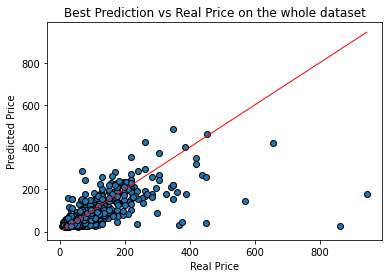

In [21]:
fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], color= 'red' , lw=1)
ax.set_xlabel('Real Price')
ax.set_ylabel('Predicted Price')
ax.set_title('Best Prediction vs Real Price on the whole dataset')
plt.show()
fig.savefig('xgbresult.png')

## Deep Neural Networks with Pytorch

In [2]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [18]:
#Building neural net
n_features= X.shape[1]

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 64) 
        self.fc2 = nn.Linear(64, 128) 
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) 
        return x
    


### Cross Valid for NN

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

kfold= KFold(n_splits= 5, shuffle= False)

def train(x, y, model):
    #define para to train
    epochs= 500
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion= nn.MSELoss()
    #refine data
    n_obs= y.shape[0]
    x, y= np.array(x), np.array(y)
    x, y= torch.Tensor(x), torch.Tensor(y).view(n_obs, 1)
    x, y= x.to(device), y.to(device)
    #other para
    model.train()
    
    #train
    for epoch in range(epochs):
        yhat= model(x)
        loss= criterion(yhat, y)
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(x, y, model):
    #refine data
    x, y= np.array(x), np.array(y)
    x, y= torch.Tensor(x), torch.Tensor(y)
    x, y= x.to(device), y.to(device)
    n_obs= y.shape[0]
    
    model.eval()
    with torch.no_grad():
        yhat= model(x) # 2-d output
        yhat= yhat.view(n_obs) #convert to 1-d output
        #convert back to cpu for sklearn module
        y=y.cpu()
        yhat= yhat.cpu()

        mse= mean_squared_error(y, yhat)
        r2= r2_score(y, yhat)
        
    return mse, r2

def nn_cv():
    mse_cv= []
    r2_cv= []
    for train_index, test_index in kfold.split(X):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        
        train_x, test_x= X.iloc[train_index], X.iloc[test_index]
        train_y, test_y= y.iloc[train_index], y.iloc[test_index]

        net_cv= Net().to(device)

        train(train_x, train_y, net_cv)

        mse, r2= test(test_x, test_y, net_cv)
        mse_cv.append(mse)
        r2_cv.append(r2)
        
    return mse_cv, r2_cv

In [20]:
mse_nn, r2_nn= nn_cv()

print('MSEs in each fold are: ', mse_nn)
print('\nR2s in each fold are: ', r2_nn)
print('\nAverage of MSE is: {:.2f}\nAverage of R2 is: {:.4f}'.format(np.mean(mse_nn), np.mean(r2_nn)))

MSEs in each fold are:  [678.6651, 1570.0938, 3670.0557, 697.8143, 596.39246]

R2s in each fold are:  [0.761796198541066, 0.5374011475928416, 0.2657118127426302, 0.6607328922556663, 0.7128506019495406]

Average of MSE is: 1442.60
Average of R2 is: 0.5877


## LightGBM

In [18]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

param_grid_lgb= {
    'max_depth': [i for i in range(3,21)],
    'num_leaves': [i for i in range(5,30)],
    'learning_rate': np.linspace(0.01, 0.65, 10),
    'n_estimator': [i for i in range(100,350,50)]
    #'n_estimator': [100,200]
}

light= lgb.LGBMRegressor(random_state= 23)

grid_search_lgb= GridSearchCV(estimator= light, param_grid= param_grid_lgb, 
                         cv= 5, refit= 'r2', n_jobs= -1,
                         scoring= ['neg_mean_squared_error', 'r2'])



In [19]:
%%time
grid_search_lgb.fit(X, y)

print(grid_search_lgb.best_params_)
print('')
print(grid_search_lgb.best_score_)

{'learning_rate': 0.0811111111111111, 'max_depth': 8, 'n_estimator': 100, 'num_leaves': 10}

0.565244685778518
Wall time: 28min 57s


In [20]:
best_lgb= grid_search_lgb.best_estimator_

from sklearn.model_selection import cross_validate

lgb_cv= cross_validate(best_lgb, X, y, cv=5, scoring= ['neg_mean_squared_error', 'r2'])
r2s_cv= lgb_cv['test_r2']
mses_cv= abs(lgb_cv['test_neg_mean_squared_error'])

print('R2 of the best model is {:.4f}'.format(np.mean(r2s_cv)))
print('MSE of the best model is {:.2f}'.format(np.mean(mses_cv)))

R2 of the best model is 0.5652
MSE of the best model is 1488.84


In [21]:
print(mses_cv)
print('')
print(r2s_cv)

[ 905.25416821 1474.64301985 3625.49271085  729.81878021  708.99935274]

[0.68226597 0.56552392 0.27462781 0.64517278 0.65863295]
